In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

from modSAR.datasource import ChEMBLApiDataSource, ChEMBLFileDataSource
from modSAR.cdk_utils import JavaCDKBridge

%matplotlib inline
from plotnine import *

# Acquiring Data from ChEMBL

The class `ChEMBLApiDataSource` interacts with the [ChEMBL webresource client API](https://github.com/chembl/chembl_webresource_client) to download bioactivities from ChEMBL. 

We must pass the ID of the target protein and the standard types we are interested in and the class will compile the compounds requested into a pandas DataFrame `bioactivities_df`:

In [2]:
chembl_id = 'CHEMBL202'
chembl_data_source = ChEMBLApiDataSource(target_id=chembl_id, standard_types=['IC50', 'Ki'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In total, the API has returned 1500+ bioactivities registered as hDHFR ligands ([CHEMBL202](https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL202)):

In [3]:
chembl_data_source.bioactivities_df.shape

(1580, 47)

Here is a peak of the data returned from ChEMBL API:

In [4]:
chembl_data_source.bioactivities_df.head()

,activity_comment,activity_id,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,ligand_efficiency_bei,ligand_efficiency_le,ligand_efficiency_lle,ligand_efficiency_sei,activity_properties,ligand_efficiency
0,NaN,40879,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2cccc(Cl)c2,NaN,NaN,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL7130,NaN,CHEMBL7130,7.03,False,http://www.openphacts.org/units/Nanomolar,347068,=,1,True,=,NaN,Ki,nM,NaN,93.33,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,NaN,NaN,Log 1/Ki,NaN,UO_0000065,NaN,7.03,27.93,0.56,5.50,8.79,NaN,NaN
1,NaN,42137,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2ccc(CCCCc3ccc(cc3Cl)S(=O...,NaN,NaN,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL33697,NaN,CHEMBL33697,7.65,False,http://www.openphacts.org/units/Nanomolar,347071,=,1,True,=,NaN,Ki,nM,NaN,22.39,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,NaN,NaN,Log 1/Ki,NaN,UO_0000065,NaN,7.65,15.29,0.33,3.25,6.70,NaN,NaN
2,NaN,42149,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2cccc(OCC34CC5CC(CC(C5)C3...,NaN,NaN,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL281618,NaN,CHEMBL281618,6.11,False,http://www.openphacts.org/units/Nanomolar,347091,=,1,True,=,NaN,Ki,nM,NaN,776.25,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,NaN,NaN,Log 1/Ki,NaN,UO_0000065,NaN,6.11,16.01,0.30,2.64,6.85,NaN,NaN
3,NaN,45682,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,NaN,NaN,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL22,TRIMETHOPRIM,CHEMBL22,6.71,False,http://www.openphacts.org/units/Nanomolar,347106,=,1,True,=,NaN,Ki,nM,NaN,194.98,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,NaN,NaN,Log 1/Ki,NaN,UO_0000065,NaN,6.71,23.11,0.44,5.45,6.36,NaN,NaN
4,NaN,46931,CHEMBL666808,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2cccc(SCc3ccccc3)c2,NaN,NaN,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL20975,NaN,CHEMBL20975,7.37,False,http://www.openphacts.org/units/Nanomolar,347115,=,1,True,=,NaN,Ki,nM,NaN,42.66,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,NaN,NaN,Log 1/Ki,NaN,UO_0000065,NaN,7.37,21.71,0.42,4.21,9.21,NaN,NaN


Standard activity types in the data set:

In [5]:
chembl_data_source.bioactivities_df['standard_type'].value_counts()

IC50            1127
Ki               405
Log 1/Ki app      38
IC50/[E]           8
Ratio IC50         2
Name: standard_type, dtype: int64

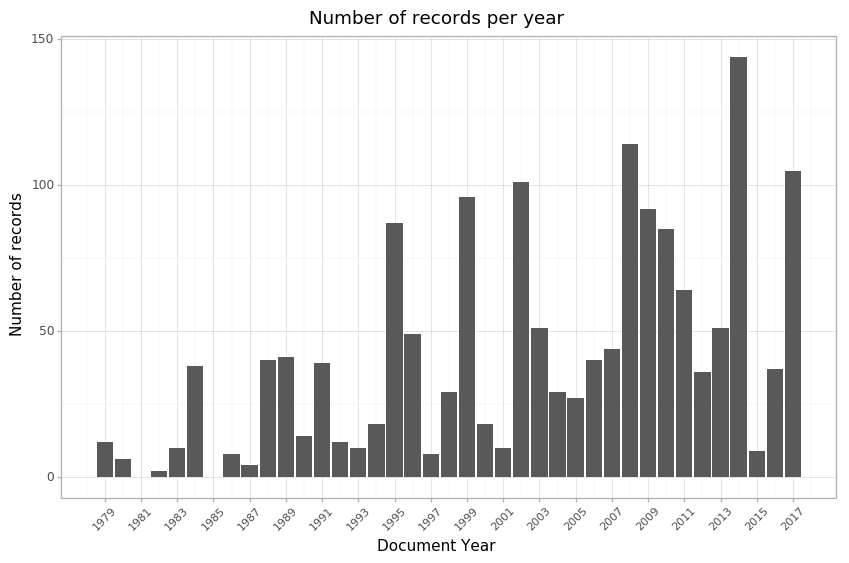

<ggplot: (8787087198717)>

In [15]:
plot_df = chembl_data_source.bioactivities_df
plot_df['document_year'] = plot_df['document_year'].astype('int')

ggplot(plot_df, aes(x='document_year')) + \
    geom_bar() + theme_light() + \
    theme(axis_text_x=element_text(angle=45, size=8), figure_size=(10, 6)) + \
    scale_x_continuous(breaks=range(min(plot_df['document_year']), max(plot_df['document_year']) + 1, 2)) + \
    xlab("Document Year") + ylab("Number of records") + \
    ggtitle("Number of records per year")

Journals where the sources came from:

In [17]:
chembl_data_source.bioactivities_df['document_journal'].value_counts()

J. Med. Chem.                    989
Bioorg. Med. Chem.               165
Bioorg. Med. Chem. Lett.         135
Eur J Med Chem                    78
Eur. J. Med. Chem.                65
Antimicrob. Agents Chemother.     22
J Med Chem                        20
Med Chem Res                      12
ACS Med. Chem. Lett.              12
MedChemComm                        7
Bioorg Med Chem Lett               7
J. Nat. Prod.                      1
Name: document_journal, dtype: int64

## Saving bioactivities to a xlsx file:

In [ ]:
chembl_data_source.save_bioactivities('/mnt/data/chembl_data/%s.xlsx' % chembl_id)

# Reading ChEMBL data from a file

If you downloaded data from ChEMBL website or saved using the `save_bioactivities` method, you can retrieve the dataframe using `ChEMBLFileDataSource` class:

In [2]:
chembl_data_source = ChEMBLFileDataSource(filepath='/mnt/data/chembl_data/CHEMBL202.xlsx', target_id='CHEMBL202')

# Preprocessing and Molecular Descriptors

To obtain a preprocessed dataset from a data source, use the method `chembl_data_source.build_qsar_dataset()`.

This method will invoke methods from `Preprocessing` and `CDKUtils` classes to filters out invalid/more inaccurate entries and to calculate molecular descriptors. 

In summary, the preprocessing step for ChEMBL data involves:

- Select only valid entries as indicated by the column `data_validity_comment`
- Select only entries where relation is of type equality (e.g.: IC50 = 30nM), as indicated by column `relation`
- Handle duplicated entries
- Remove data marked as outliers

Method `.build_qsar_dataset()` will calculate molecular descriptors and apply filters to produce a `QSARDataset` that represents the final dataset.

The filters on molecular descriptors are applied in two steps:
- Remove near zero variance features
- Remove features that are highly correlated

In [9]:
from modSAR.cdk_utils import CDKUtils
cdk_utils = CDKUtils()

CDK Bridge process running


In [3]:
qsar_dataset = chembl_data_source.build_qsar_dataset()

Starting CDKBridge
(01/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.WHIMDescriptor()
(02/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.BCUTDescriptor()
(03/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.XLogPDescriptor()
(04/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.WeightDescriptor()
(05/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.RuleOfFiveDescriptor()
(06/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.RotatableBondsCountDescriptor()
(07/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.MannholdLogPDescriptor()
(08/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.LargestPiSystemDescriptor()
(09/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.LargestChainDescriptor()
(10/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecul

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/py4j/java_gateway.py", line 1181, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/opt/conda/lib/python3.6/site-packages/gevent/_socket3.py", line 433, in recv_into
    self._wait(self._read_event)
  File "src/gevent/_hub_primitives.py", line 284, in gevent.__hub_primitives.wait_on_socket
  File "src/gevent/_hub_primitives.py", line 289, in gevent.__hub_primitives.wait_on_socket
  File "src/gevent/_hub_primitives.py", line 271, in gevent.__hub_primitives._primitive_wait
  File "src/gevent/_hub_primitives.py", line 46, in gevent.__hub_primitives.WaitOperationsGreenlet.wait
  File "src/gevent/_hub_primitives.py", line 46, in gevent.__hub_primitives.WaitOperationsGreenlet.wait
  File "src/gevent/_hub_primitives.py", line 55, in gevent

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/py4j/java_gateway.py", line 1181, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/opt/conda/lib/python3.6/site-packages/gevent/_socket3.py", line 433, in recv_into
    self._wait(self._read_event)
  File "src/gevent/_hub_primitives.py", line 284, in gevent.__hub_primitives.wait_on_socket
  File "src/gevent/_hub_primitives.py", line 289, in gevent.__hub_primitives.wait_on_socket
  File "src/gevent/_hub_primitives.py", line 271, in gevent.__hub_primitives._primitive_wait
  File "src/gevent/_hub_primitives.py", line 46, in gevent.__hub_primitives.WaitOperationsGreenlet.wait
  File "src/gevent/_hub_primitives.py", line 46, in gevent.__hub_primitives.WaitOperationsGreenlet.wait
  File "src/gevent/_hub_primitives.py", line 55, in gevent

Py4JError: org.openscience.cdk.fingerprint.CircularFingerprinter does not exist in the JVM

In [4]:
print(qsar_dataset)

NameError: name 'qsar_dataset' is not defined

In [ ]:
qsar_dataset.X.head()

In [ ]:
import altair as alt

alt.renderers.enable('notebook')

chart = alt.Chart(preprocessed_df).mark_bar().encode(
    x=alt.X("median_pchembl_value", bin=True, title='Median pChEMBL value'),
    y='count()',
    tooltip=['count()'],
).properties(
    title='Activities distribution'
)

chart

![Activities distribution](fig/notebook01/fig01_activities_distribution.png)